In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import os
import tensorflow
from PIL import Image, ImageOps
from tensorflow.keras.models import Model
from tensorflow.keras import layers , regularizers
from tensorflow.keras import *
from sklearn.model_selection import StratifiedKFold

In [ ]:
tumor_files=os.listdir('Brain Tumor')
healthy_files=os.listdir('Healthy')

In [ ]:
len(tumor_files) , len(healthy_files)
# convert images to grayscales 
x= np.zeros((len(tumor_files)+len(healthy_files), 128,128) , dtype = np.float32)
for i in range(len(tumor_files)):
    image= Image.open(tumor_files[i])
    x[i, :, :] = np.asarray(ImageOps.grayscale(image).resize((128, 128)))

for i in range(len(healthy_files)):
    image= Image.open(healthy_files[i])
    x[i +len(tumor_files),:,:]= np.asarray(ImageOps.grayscale(image).resize((128, 128)))
    
y= np.array([True]* len(tumor_files)+[False]*len(healthy_files))

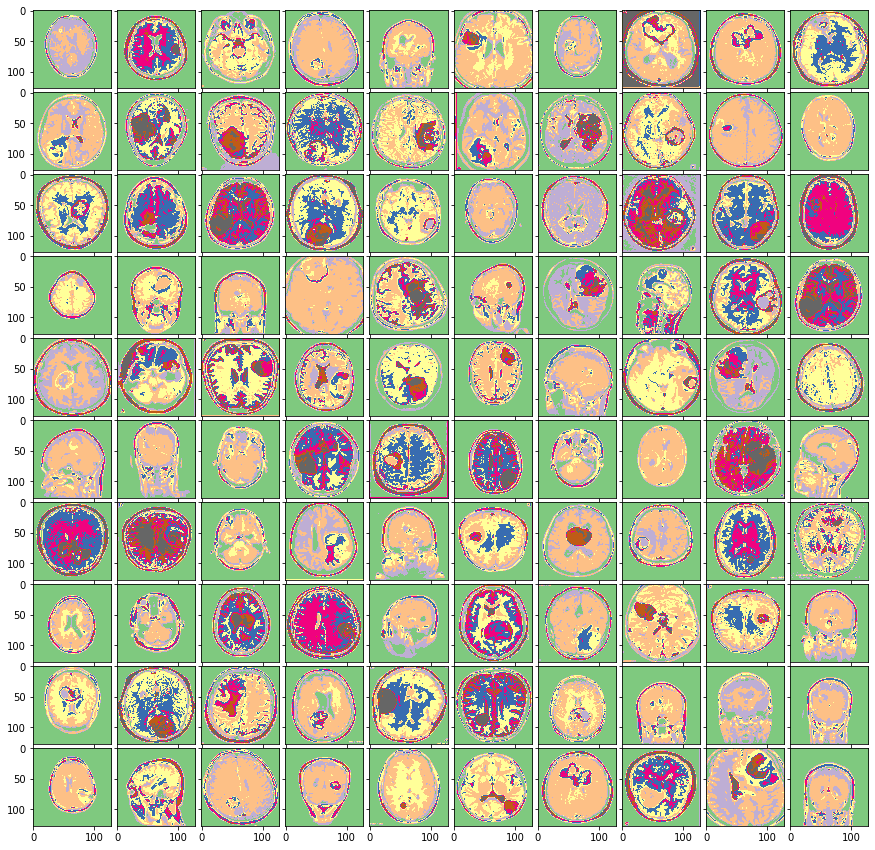

In [ ]:
i = np.random.randint(len(tumor_files), size = 100)

fig, axs = plt.subplots(10, 10, sharex = True, sharey = True, figsize = (15, 15))
plt.subplots_adjust(wspace = .05, hspace = .05)

x1 = x[i, :, :]

for i in range(10):
    for j in range(10):
        k = i * 10 + j
        axs[i][j].imshow(x1[k, :, :], cmap = 'Accent')
        axs[i][j].axes.get_xaxis()
        axs[i][j].axes.get_yaxis()

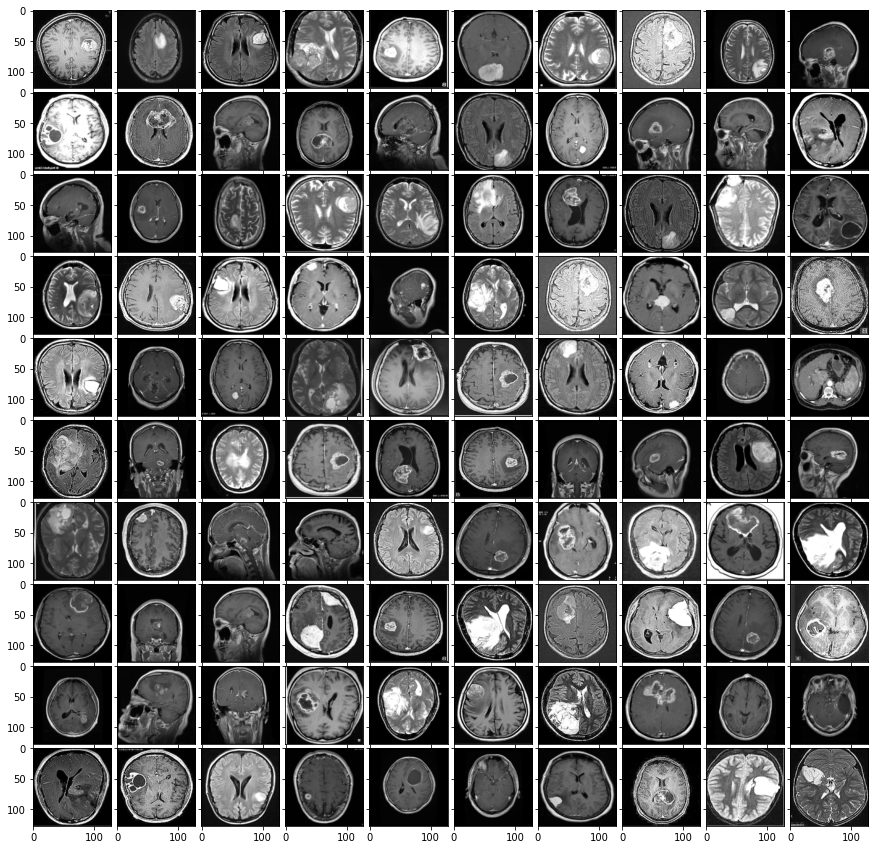

In [ ]:
i = np.random.randint(len(healthy_files), size = 100)

fig, axs = plt.subplots(10, 10, sharex = True, sharey = True, figsize = (15, 15))
plt.subplots_adjust(wspace = .05, hspace = .05)

x1 = x[i, :, :]

for i in range(10):
    for j in range(10):
        k = i * 10 + j
        axs[i][j].imshow(x1[k, :, :], cmap = 'gray')
        axs[i][j].axes.get_xaxis()
        axs[i][j].axes.get_yaxis()

In [ ]:
#Model
def model(input,classes):
    branches=1
    alpha=1e-3
    input= layers.Input(shape=input)
    regularizer= regularizers.L2(alpha)
    preprocess = layers.experimental.preprocessing.Rescaling(1./255)(input)
    branch=[preprocess]*branches
    for i in range(branches):
        for size in [32, 64, 128, 128, 128, 128, 128]:
            branch[i]=layers.Conv2D(
            filters= size,
            kernel_size = 3,
            padding='same',
            kernel_regularizer= regularizer,
            bias_regularizer=regularizer)(branch[i])
            branch[i]= layers.MaxPool2D()(branch[i])
            branch[i]=layers.ReLU()(branch[i])
            branch[i]=layers.Dropout(0.3)(branch[i])
    out = layers.Flatten()(branch[0])         
    out= layers.Dense(
        units = 128,
        kernel_regularizer=regularizer,
        bias_regularizer=regularizer
    )(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    out = layers.Dropout(0.3)(out)
    outputs = layers.Dense(units=classes)(out)
    return Model(input,outputs)

In [ ]:
Final_Model = model((x.shape[1], x.shape[2], 1), 2)

In [ ]:
checkpoint1='checkpoint'
split= StratifiedKFold(n_splits= 10,random_state= 42,shuffle= True)
split_score=np.zeros(10)

for train, valid in split.split(x,y):
    x_train=x[train,:]
    x_valid=x[valid,:]
    y_train=y[train]
    y_valid=y[valid]
    loss= tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer= tensorflow.keras.optimizers.Adam(1e-5)
    
    train_model=model((x.shape[1], x.shape[2], 1),2)
    train_model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
    
    checkpoint_check= tensorflow.keras.callbacks.ModelCheckpoint( filepath=checkpoint1,
        save_weights_only= True,
        mode='max',
        monitor='val_accuracy',
        save_best_only='True'
    )
    early_stop = tensorflow.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 50,
        mode = 'max'
    )
    
    train_model.fit(
        x_train, y_train,
        validation_data = (x_valid, y_valid),
        epochs = 50,
        callbacks = [checkpoint_check, early_stop],
    )
    
    
    split_score[k] = train_model.evaluate(x_valid, y_valid)[1]
    
 